<a href="https://colab.research.google.com/github/thatgeeman/pybx/blob/master/nbs/pybx_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyBx

PyBx is a simple python module to generate anchor boxes 
(aka default boxes aka prior boxes) for object detection
tasks. 

### Links

Project page: [GitHub](https://github.com/thatgeeman/pybx) 

Package: [PyBx](https://pypi.org/project/pybx/)

In [47]:
! pip install pybx==0.1.1

  Attempting uninstall: pybx
    Found existing installation: pybx 0.1.0
    Uninstalling pybx-0.1.0:
      Successfully uninstalled pybx-0.1.0


# SSD for Object Detection

This walkthrough is build around the [Single-Shot Detection (SSD)](https://arxiv.org/pdf/1512.02325.pdf) algorithm. The SSD can be imagined as an encoder-decoder model architecture, where the input image is fed into a `backbone` (encoder) to generate inital features, which then goes through a series of 2D convolution layers (decoders) to perform further feature extraction/prediction tasks at each layer. For a single image, each layer in the decoder produces a total of `N x (4 + C)` predictions. Here `C` is the number of classes (plus one for `background` class) in the detection task and 4 comes from the corners of the rectangular bounding box. 

### Usage of the term Feature/Filter/Channel

Channel: RGB dimensione, also called a Filter

Feature: (W,H) of a single channel

## Example case 
For this example, we assume that our input image is a single channel image is of shape `[B, 3, 300, 300]` where `B` is the batch size. Assuming that a pretrained `VGG-16` is our model `backbone`, the output feature shape would be: `[B, 512, 37, 37]`. Meaning that, 512 channels of shape `[37, 37]` were extracted from each image in the batch. In the subsequent decoder layers, for simplicity we double the channels while halving the feature shape using `3x3` `stride=2` convolutions (except for first decoder layer where convolution is not applied). This results in the following shapes:

```python
torch.Size([-1, 512, 37, 37])  # inp from vgg-16 encoder
torch.Size([-1, 1024, 18, 18]) # first layer logits
torch.Size([-1, 2048, 8, 8])   # second layer logits
torch.Size([-1, 4096, 3, 3])   # third layer logits
```

<img src="https://lilianweng.github.io/lil-log/assets/images/SSD-box-scales.png" width="500" />

## Sample image
Image obtained from USC-SIPI Image Database. 
The USC-SIPI image database is a collection of digitized images. It is maintained primarily to support research in image processing, image analysis, and machine vision. The first edition of the USC-SIPI image database was distributed in 1977 and many new images have been added since then.

In [1]:
! wget -q -O 'image.jpg' 'https://sipi.usc.edu/database/download.php?vol=misc&img=5.1.12'

## About anchor Boxes

We are expected to provide our models with "good" anchor (aka default/prior) boxes. Strong opinion: Our model is [only as good as the initial anchor boxes](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) that we generate. Inorder to improve the coverage of our model, we tend to add additional anchor boxes of different aspect ratios. Now, for a single image, each layer in the decoder produces a total of `N x A x (4 + C)` predictions. Here `A` is the number of aspect ratios to generate additional anchor boxes.

### Task description

Our aim is to find the maximum number of anchor boxes in varying sizes `feature_szs` and aspect ratios `asp_ratios` across the entire image. We apply no filtering to get rid of low (IOU) anchors.

<img src="https://lilianweng.github.io/lil-log/assets/images/SSD-framework.png" width="600" />

In [2]:
feature_szs = [(37,37), (18,18), (8,8), (3,3)]

In [3]:
asp_ratios = [1., 2.,  1/2., 1/3.]

In [4]:
from operator import __mul__

In [5]:
n_boxes = sum([__mul__(*f) for f in feature_szs]) 
print(f'minimum anchor boxes with 1 aspect ratio: {n_boxes}')
print(f'minimum anchor boxes with {len(asp_ratios)} aspect ratios: {n_boxes*len(asp_ratios)}')

minimum anchor boxes with 1 aspect ratio: 1766
minimum anchor boxes with 4 aspect ratios: 7064


# Loading an image

In [6]:
from PIL import Image
from matplotlib import pyplot as plt
import json

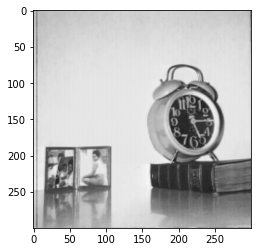

In [7]:
im = Image.open("image.jpg").convert('RGB').resize([300,300])
_ = plt.imshow(im)

We also make 2 truth bounding boxes `bbox` for this image around the clock and the photoframe in `pascal voc` format:

In [8]:
bbox = [dict(x_min=150, y_min=70, x_max=270, y_max=220, label='clock'),
        dict(x_min=10, y_min=180, x_max=115, y_max=260, label='frame'),]
bbox

[{'label': 'clock', 'x_max': 270, 'x_min': 150, 'y_max': 220, 'y_min': 70},
 {'label': 'frame', 'x_max': 115, 'x_min': 10, 'y_max': 260, 'y_min': 180}]

Save annotations as a json file.

In [9]:
with open('annots.json', 'w') as f:
  f.write(json.dumps(bbox))

# Using PyBx

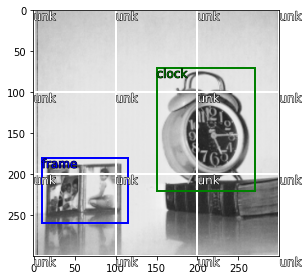

In [10]:
from pybx import anchor

image_sz = (300, 300, 3)  # W, H, C
feature_sz = (3, 3)       # number of features along W, H of the image 
asp_ratio = 1.            # aspect ratio of the anchor box

anchors = anchor.bx(image_sz, feature_sz, asp_ratio, show=True)

The boxes in white with label `unk` are the anchor boxes. We can hightlight them with a different color.

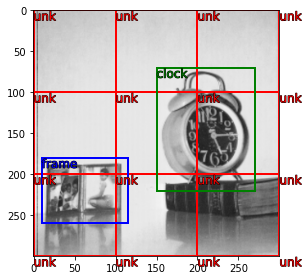

In [11]:
anchors = anchor.bx(image_sz, feature_sz, asp_ratio, show=True, color={'unk':'red'})

We can also overlay the features/receptive fields on the original image (only for reference and visualisation).

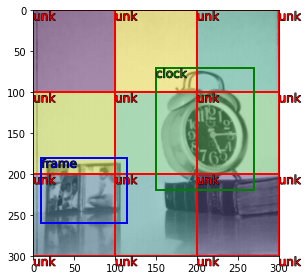

In [12]:
anchors = anchor.bx(image_sz, feature_sz, asp_ratio, show=True, color={'unk':'red'}, logits=True)

`logits=True` simply generates numbers of the same shape as feature sizes for illustration purposes. 

# Working with mulitple feature sizes and aspect ratios
Finally we calculate anchor boxes for multiple feature sizes and aspect ratios.

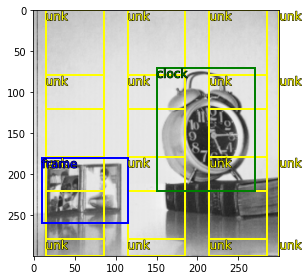

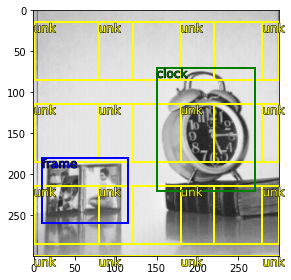

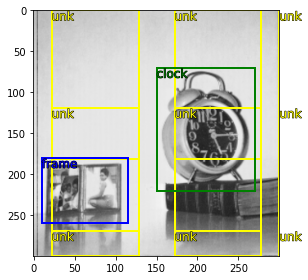

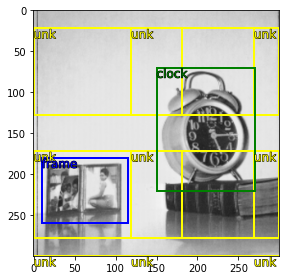

In [15]:
feature_szs = [(3, 3), (2, 2)]
asp_ratios = [1/2., 2.]

anchors = anchor.bxs(image_sz, feature_szs, asp_ratios, show=True, color={'unk': 'yellow'})

This is essentially a wrapper to do list comprehension over the passed feature sizes and aspect ratios (but additionally stacks them together into an ndarray).

```
[anchor.bxs(image_sz, f, ar) for f in feature_szs for ar in asp_ratios]
```

As simple as that! More options to select the best anchors planned. Do leave a star or raise issues and suggestions on the project page if you found this useful! 

Project page: [GitHub](https://github.com/thatgeeman/pybx) 

Package: [PyBx](https://pypi.org/project/pybx/)